# Energy Carbon: Marketshare by Country Weighting
In this first section we will determine the country-wise countribution to each of the energy steps of the silicon supply chain to correctly attribute carbon intensities to grids.

In [1]:
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10, 6)
cwd = os.getcwd() #grabs current working directory
carbonfolder = str(Path().resolve().parent.parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial' / 'CarbonIntensities')
supportmatfolder = str(Path().resolve().parent.parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')

Pull in crunched data from BNEF commissioned capacity to create country marketshare. Everything that was less than 1% of global marketshare was excluded (things don't currently sum to 100). 

In [2]:
#skipcols = ['Source', 'Notes','Country']
mrktshare_country_si_cell = pd.read_csv(os.path.join(carbonfolder, 'input-silicon-CountryMarketshare-cell.csv'),
                                     index_col='Country')#, usecols=lambda x: x not in skipcols)
mrktshare_country_si_wafer = pd.read_csv(os.path.join(carbonfolder, 'input-silicon-CountryMarketshare-wafer.csv'),
                                     index_col='Country')#, usecols=lambda x: x not in skipcols)
mrktshare_country_si_ingot_multi = pd.read_csv(os.path.join(carbonfolder, 'input-silicon-CountryMarketshare-ingot-multi.csv'),
                                     index_col='Country')#, usecols=lambda x: x not in skipcols)
mrktshare_country_si_ingot_mono = pd.read_csv(os.path.join(carbonfolder, 'input-silicon-CountryMarketshare-ingot-mono.csv'),
                                     index_col='Country')#, usecols=lambda x: x not in skipcols)
mrktshare_country_si_polysi = pd.read_csv(os.path.join(carbonfolder, 'input-silicon-CountryMarketshare-polysilicon.csv'),
                                     index_col='Country')#, usecols=lambda x: x not in skipcols)
#mrktshare_country_si_silica = pd.read_csv(os.path.join(carbonfolder, 'input-silicon-CountryMarketshare-silica.csv'),
#                                     index_col='Country')#, usecols=lambda x: x not in skipcols)


Pull in silicon energy files to create a % of energy attributable to each step of the MFGing process. This will be multiplied by the country market shares to create an overall country marketshare of the energy supply chain (i.e. energy weighted...)

Also the mono vs multi to attribute marketshare of these two technologies.

In [3]:
energy_silicon_mfg = pd.read_csv(os.path.join(supportmatfolder, 'output_energy_silicon_mfg.csv'),
                                     index_col=0)#, usecols=lambda x: x not in skipcols)
marketshare_silicon_monoVmulti = pd.read_csv(os.path.join(supportmatfolder, 'output_scaledmrktshr_mcSi_mono.csv'),
                                     index_col=0)#, usecols=lambda x: x not in skipcols)
energy_silicon_mfg_STEPS_raw = pd.read_csv(os.path.join(supportmatfolder, 'output_energy_silicon_mfg_STEPS.csv'),
                                     index_col=0)#, usecols=lambda x: x not in skipcols)

In [4]:
energy_silicon_mfg_STEPS = energy_silicon_mfg_STEPS_raw.filter(like="kWhpkg") #drop the fuel fraction columns
energy_silicon_mfg.drop(['E_mfgFuelFraction'], axis=1, inplace=True) #drop fuel fraction


In [5]:
energyShare_silicon_mfg_STEPS = energy_silicon_mfg_STEPS.div(energy_silicon_mfg.values)
#sanity check that everything adds to 100% or 1
#energyShare_silicon_mfg_STEPS.sum(axis=1)

In [6]:
energyShare_silicon_mfg_STEPS.columns

Index(['E_reduce_sum_kWhpkg', 'E_refineSiemens_kWhpkg', 'E_Ingot_kWhpkg',
       'E_Wafering_kWhpkg', 'E_cellProcess_kWhpkg'],
      dtype='object')

The math is:

    % of energy for mfging step * % country contribution, then sum for each country across all energy steps to get the country contribution to MFGing energy

In [7]:
energyShare_silicon_mfg_STEPS_subset = energyShare_silicon_mfg_STEPS.loc[2004:2022]
#energyShare_silicon_mfg_STEPS_subset

### Cell

In [8]:
energy_cell_fract = energyShare_silicon_mfg_STEPS_subset['E_cellProcess_kWhpkg']

In [9]:
mrktshare_country_si_cell_fractbyyear = mrktshare_country_si_cell/100 #turn it into a decimal

In [10]:
cell_by_country = mrktshare_country_si_cell_fractbyyear*energy_cell_fract.values*100
# sanity check: that all countries each year add to the value from energy_cell_fract or pretty close
#cell_by_country.sum()/100

### Wafer

In [11]:
energy_wafer_fract = energyShare_silicon_mfg_STEPS_subset['E_Wafering_kWhpkg']
#energy_wafer_fract

In [12]:
mrktshare_country_si_wafer_fractbyyear = mrktshare_country_si_wafer/100 #turn it into a decimal
#mrktshare_country_si_wafer_fractbyyear

In [13]:
wafer_by_country = mrktshare_country_si_wafer_fractbyyear*energy_wafer_fract.values*100
# sanity check: that all countries each year add to the value from energy_cell_fract or pretty close
#wafer_by_country.sum()/100
#wafer_by_country

### Ingot
More complicated due to mono vs multi marketshare. The total ingot energy is already weighted by this marketshare. Math is:
        
        (mono% * % mono country production + multi% * % multi country production)* Ingot % of energy.

In [14]:
marketshare_silicon_monoVmulti_subset = marketshare_silicon_monoVmulti.loc[2004:2022] #in fraction form
marketshare_silicon_monoVmulti_subset.head()

,monoSi,mcSi
Year,,
2004,0.080000,0.920000
2005,0.309000,0.691000
2006,0.270000,0.730000
2007,0.353535,0.646465
2008,0.454545,0.545455


In [15]:
energy_ingot_fract = energyShare_silicon_mfg_STEPS_subset['E_Ingot_kWhpkg']
#energy_ingot_fract

In [16]:
mrktshare_country_si_ingot_multi_fractbyyear = mrktshare_country_si_ingot_multi/100 #turn it into a decimal
mrktshare_country_si_ingot_mono_fractbyyear = mrktshare_country_si_ingot_mono/100 #turn it into a decimal

In [17]:
#mono multi deployment marketshares * the countrywise marketshare of mfging these techs
country_multi = mrktshare_country_si_ingot_multi_fractbyyear*marketshare_silicon_monoVmulti_subset['mcSi'].values
country_mono = mrktshare_country_si_ingot_mono_fractbyyear*marketshare_silicon_monoVmulti_subset['monoSi'].values

In [18]:
#weight both by the ingot energy
country_multi_energy = country_multi*energy_ingot_fract.values
country_mono_energy = country_mono*energy_ingot_fract.values

In [19]:
country_multi_energy.index

Index(['China', 'Germany', 'India', 'Korea', 'Taiwan', 'United Kingdom'], dtype='object', name='Country')

In [20]:
country_mono_energy.index

Index(['China', 'Germany', 'Korea', 'Malaysia', 'Norway', 'Qatar', 'Taiwan',
       'Ukraine', 'United States', 'Vietnam'],
      dtype='object', name='Country')

In [21]:
#keeps all countries, while grouping and summing any duplicates
country_wtdenergy_ingot = pd.concat([country_mono_energy, country_multi_energy]).groupby(['Country']).sum()
#sanity check that sums by year are the same as the ingot energy fraction
#country_wtdenergy_ingot.sum(axis=0)

In [22]:
ingot_by_country = country_wtdenergy_ingot*100
ingot_by_country

,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Country,,,,,,,,,,,,,,,,,,,
China,0.000000,5.519196,7.590382,8.505338,11.451192,16.067834,17.152128,15.236926,15.791873,14.885968,14.548198,15.061001,13.965185,13.323674,14.721146,15.282635,19.894537,20.390643,20.503944
Germany,0.000000,0.000000,1.852117,1.028827,0.667098,0.213418,0.093239,0.058072,0.054425,0.052625,0.234961,0.256097,0.176213,0.123575,0.000000,0.000000,0.000000,0.000000,0.000000
India,7.905386,0.085119,0.037042,0.014698,0.009530,0.003049,0.001332,0.000830,0.000778,0.000752,0.000666,0.000452,0.000331,0.000193,0.000159,0.000137,0.000082,0.000070,0.000077
Korea,0.000000,0.000000,0.000000,3.180082,3.978249,2.974522,2.598953,1.492666,1.368973,0.835120,0.698940,1.174731,0.807688,0.523603,0.278556,0.014329,0.012545,0.008116,0.007779
Malaysia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.119765,0.080872,0.059681,0.047213,0.028659,0.025090,0.016232,0.015559
Norway,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.570988,0.315416,0.288327,0.251491,0.207153,0.219569,0.148266,0.109416,0.086557,0.052541,0.045999,0.029758,0.028525
Qatar,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.112993,0.119765,0.080872,0.059681,0.047213,0.028659,0.025090,0.016232,0.015559
Taiwan,0.000000,0.000000,1.500215,3.644986,3.521799,2.015291,1.024193,1.755062,1.705056,1.609481,1.412965,1.086842,0.833497,0.504296,0.299673,0.258546,0.153809,0.132398,0.145654
Ukraine,0.000000,0.000000,0.000000,0.124581,0.129555,0.087683,0.030996,0.017123,0.015652,0.008688,0.007156,0.007585,0.008087,0.005968,0.004721,0.002866,0.002509,0.001623,0.001556


### Polysilicon

In [23]:
energy_polysi_fract = energyShare_silicon_mfg_STEPS_subset['E_refineSiemens_kWhpkg']
#energy_polysi_fract

In [24]:
mrktshare_country_si_polysi_fractbyyear = mrktshare_country_si_polysi/100 #turn it into a decimal

In [25]:
polysi_by_country = mrktshare_country_si_polysi_fractbyyear*energy_polysi_fract.values*100
# sanity check: that all countries each year add to the value from energy_cell_fract or pretty close
polysi_by_country#.sum()/100

,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Country,,,,,,,,,,,,,,,,,,,
China,0.000000,0.552362,0.459965,2.095158,6.079165,12.449101,13.808707,22.892185,20.714104,22.566285,22.735962,23.746421,23.722909,26.207230,27.827566,32.982877,33.795911,34.276461,34.617097
United States,51.047600,30.564010,33.577443,25.910118,26.869911,16.281707,15.614558,11.050723,9.588113,8.990210,8.323970,7.929563,8.867698,8.033052,7.195380,4.373285,4.138469,3.269695,3.302189
Germany,0.000000,10.126630,9.965908,11.639766,8.092889,8.637100,8.108675,5.760977,8.095924,7.591072,7.028518,6.695492,6.932393,6.283987,5.628705,4.320469,4.088489,3.230207,3.262309
Malaysia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.855448,1.767533,1.591136,1.442312,1.591484,1.940169,1.835995,1.450571,1.464987
Japan,7.531613,13.809041,12.265733,10.336112,6.747873,4.079871,3.273736,2.763127,2.443877,2.291480,2.121665,2.021135,1.798675,1.599085,1.432336,1.099429,1.040397,0.821990,0.830159
Qatar,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.376255,0.748934,0.574865,0.543999,0.429799,0.434070
Norway,0.000000,0.000000,0.000000,0.000000,0.000000,2.060541,1.513283,1.070979,0.929231,0.871285,0.806717,0.768493,0.691798,0.627092,0.786380,0.000000,0.000000,0.376074,0.379811
Korea,0.000000,0.000000,0.000000,0.000000,0.000000,5.838199,8.373499,8.603535,9.013539,8.451466,9.169678,8.350953,8.878075,8.047684,5.804236,4.455203,0.441999,0.349212,0.352682
Russia,0.000000,0.000000,0.000000,0.000000,0.227969,0.961586,0.706199,1.070979,1.161539,1.089106,0.336132,0.320205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### MG-Si
from USGS

In [26]:
mrktshare_country_si_mgsi = pd.read_csv(os.path.join(carbonfolder, 'input-silicon-CountryMarketshare-mgSi.csv'),
                                     index_col='Country')#, usecols=lambda x: x not in skipcols)

In [27]:
energy_reducesilica_fract = energyShare_silicon_mfg_STEPS_subset.loc[2007:2021,'E_reduce_sum_kWhpkg']
#energy_reducesilica_fract

In [28]:
mrktshare_country_si_silica_fractbyyear = mrktshare_country_si_mgsi/100 #turn it into a decimal
#mrktshare_country_si_silica_fractbyyear

In [36]:
silicareduce_by_country = mrktshare_country_si_silica_fractbyyear*energy_reducesilica_fract.values*100
# sanity check: that all countries each year add to the value from energy_cell_fract or pretty close
silicareduce_by_country

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Country,,,,,,,,,,,,,,,
China,9.323833,9.554913,9.949105,9.761955,10.639593,10.296218,11.527797,11.917482,11.985976,11.875785,12.005621,11.292780,10.648176,9.478419,8.982925
United States,0.215920,0.215420,0.194373,0.210653,0.299485,0.332369,0.267922,0.367660,0.315291,0.266230,0.282037,0.254029,0.201882,0.162166,0.141455
Norway,1.430786,1.346374,1.502886,1.498546,1.379206,1.354766,1.192531,1.048459,0.920111,0.847867,0.816709,0.704331,0.722727,0.642376,0.516260
Brazil,1.305337,1.146068,1.322540,1.130332,1.040316,1.201225,1.065327,0.645152,0.637943,1.073964,0.892935,0.953195,0.963636,0.853507,0.681463
France,1.177747,1.024982,0.804545,0.959069,0.819643,0.859825,0.795021,0.698973,0.754491,0.853519,0.811264,0.647985,0.505909,0.390816,0.344173
Russia,0.529986,0.469059,0.239460,0.417024,0.456320,0.474168,0.437261,0.419384,0.368044,0.335190,0.322872,0.278446,0.285718,0.253806,0.206504
South Africa,0.490728,0.449950,0.386743,0.397329,0.463413,0.478684,0.271102,0.329915,0.284008,0.150355,0.025590,0.239473,0.159000,0.000000,0.000000
Germany,0.345914,0.252701,0.276731,0.257793,0.237491,0.261921,0.222606,0.213187,0.187089,0.172400,0.163342,0.140866,0.000000,0.289137,0.220271
Australia,0.343510,0.304020,0.300577,0.256894,0.236435,0.270953,0.238506,0.335507,0.294435,0.271317,0.272236,0.187822,0.236091,0.193162,0.175528


In [58]:
#extend data 2004-2022
silicareduce_by_country_rotate = silicareduce_by_country.T
idx_extend = pd.Index(range(2004,2023,1))
temp = pd.DataFrame(index=idx_extend, columns=silicareduce_by_country_rotate.columns)


ValueError: columns overlap but no suffix specified: Index(['China', 'United States', 'Norway', 'Brazil', 'France', 'Russia',
       'South Africa', 'Germany', 'Australia', 'Spain', 'Canada', 'Bosnia',
       'Uzbekistan', 'Iceland', 'Kazakhstan', 'Laos', 'Slovakia', 'Thailand'],
      dtype='object', name='Country')

# Sum MFGing by country contributions

In [32]:
mfging_si_bycountry = pd.concat([cell_by_country, wafer_by_country, ingot_by_country, 
           polysi_by_country, silicareduce_by_country]).groupby(['Country']).sum()

In [33]:
mfging_si_bycountry.sum()

2004    83.521687
2005    84.505941
2006    83.879253
2007    99.980509
2008    99.483697
2009    99.729761
2010    99.818729
2011    99.786490
2012    98.997952
2013    98.594367
2014    99.000335
2015    99.483285
2016    99.763206
2017    99.841609
2018    99.835364
2019    99.808836
2020    99.691085
2021    99.814055
2022    88.961192
dtype: float64

We're pretty close to 100%, so will renormalize at this point.

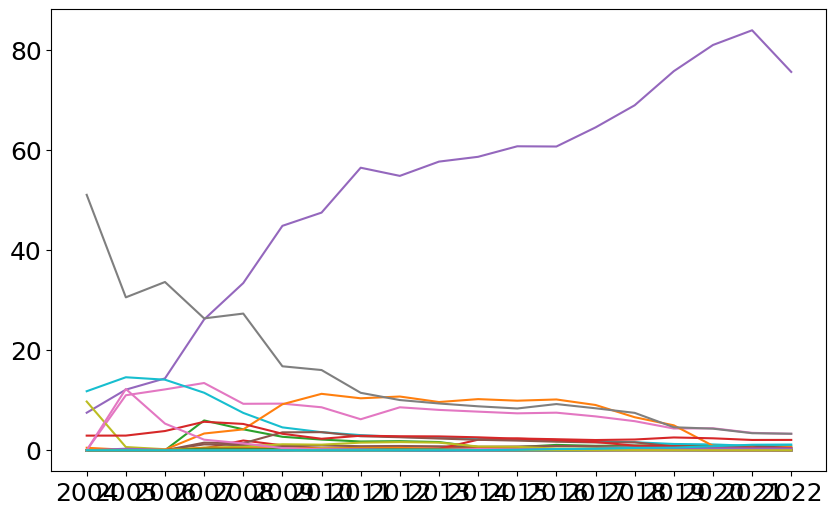

In [35]:
#normalize all marketshares each year to make sure everything adds to 100%
scaling['Scale'] = 1/mfging_si_bycountry.sum()
est_mrktshrs['monoSi_scaled']= est_mrktshrs['Scale']*est_mrktshrs['monoSi']
est_mrktshrs['mcSi_scaled']= est_mrktshrs['Scale']*est_mrktshrs['mcSi']

scaled_marketshares = est_mrktshrs[['monoSi_scaled','mcSi_scaled']]
scaled_marketshares.columns = ['monoSi','mcSi']
scaled_marketshares.to_csv(cwd+'/../../../PV_ICE/baselines/SupportingMaterial/output_scaledmrktshr_mcSi_mono.csv', index=True)
scaled_marketshares['Total'] = scaled_marketshares['monoSi']+scaled_marketshares['mcSi']